# Demo of SITAR on Synthetic Data
### Zhenwen Dai (2017.1.27)

In [1]:
import numpy as np
import GPy
import scipy
import os
from pylab import *
from sitar_model import SITAR
%matplotlib inline

In [2]:
# Visualization Utility Functions
def ax_default(fignum, ax):
    if ax is None:
        fig = pb.figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol,linewidth=0.2,ax=axes))
    plots.append(meanplot(x, lower,color=edgecol,linewidth=0.2,ax=axes))

    return plots

## Generate Synthetic Data

In [3]:
# Load a real connection matrix
X = np.loadtxt('Z_qval9_38.out')
X = (X>0)*1
# Select the first 20 motifs
X = X[:,:20]
X = X[X.sum(1)>0]

In [4]:
np.random.seed(1)

In [5]:
# Generate Synthetic data
num_exp = 94
num_gene = X.shape[0]
num_tf = X.shape[1]
sigma = np.sqrt(0.1)

num_conn = (X>0).sum()
X_gt = X.copy()
X_gt[X>0] = (np.random.rand(num_conn)<0.66)*1
for i in range(X.shape[0]):
    if X_gt[i].sum()==0:
        idx = np.where(X[i]==1)[0]
        X_gt[i,idx[np.random.randint(len(idx))]] = 1
        

A = np.zeros(X.shape)
A[X_gt>0] = np.random.randn(X_gt[X>0].sum())

P = np.random.randn(num_tf, num_exp)

E = A.dot(P)+ np.random.randn(num_gene,num_exp)*sigma

In [6]:
print('The number of gene: %d' % num_gene)
print('The number of TF: %d' % num_tf)
print('The number of experiments: %d' % num_exp)

The number of gene: 353
The number of TF: 20
The number of experiments: 94


## Train the Model

In [7]:
m = SITAR(E,X)
print(m)


Name : SITAR
Objective : 1638839.66059
Number of Parameters : 21622
Number of Optimization Parameters : 14630
Updates : True
Parameters:
  SITAR.                    |      value  |         constraints          |  priors
  latent_space.mean         |  (353, 20)  |                              |        
  latent_space.variance     |  (353, 20)  |             +ve              |        
  latent_space.binary_prob  |  (353, 20)  |  {fixed} 1e-10,0.9999999999  |        
  latent_space.tau_         |    (20, 2)  |             +ve              |        
  inducing_inputs           |   (20, 20)  |            fixed             |        
  linear.variances          |        1.0  |          fixed +ve           |        
  Gaussian_noise.variance   |       0.01  |             +ve              |        


 /Users/zhenwen/workspace/codes/GPy_thang/GPy/models/ss_gplvm.py:196: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


In [8]:
m.optimize(max_iters=10000)

In [9]:
print(m)


Name : SITAR
Objective : 15589.46162
Number of Parameters : 21622
Number of Optimization Parameters : 14630
Updates : True
Parameters:
  SITAR.                    |           value  |         constraints          |  priors
  latent_space.mean         |       (353, 20)  |                              |        
  latent_space.variance     |       (353, 20)  |             +ve              |        
  latent_space.binary_prob  |       (353, 20)  |  {fixed} 1e-10,0.9999999999  |        
  latent_space.tau_         |         (20, 2)  |             +ve              |        
  inducing_inputs           |        (20, 20)  |            fixed             |        
  linear.variances          |             1.0  |          fixed +ve           |        
  Gaussian_noise.variance   |  0.102290130807  |             +ve              |        


## Results and Plots

In [10]:
# Read out the variational posterior from the model
x_mean = m.X.mean.values.copy()    # The posterior mean of control strength (A)
x_var = m.X.variance.values.copy() # The posterior variance of control strength (A)
x_gamma = m.X.gamma.values.copy()  # THe posterior probability of connections (X)

In [11]:
# Read out the estimated connection matrix (x) by thresholding the posterior probability

# Threshold by the posterior mean of hyper-parameters
# th = m.X.tau[:,0]/m.X.tau.sum(1)
# conn = (m.X.gamma>th)*1

# Threshold by 0.5
conn = (m.X.gamma>0.5)*1

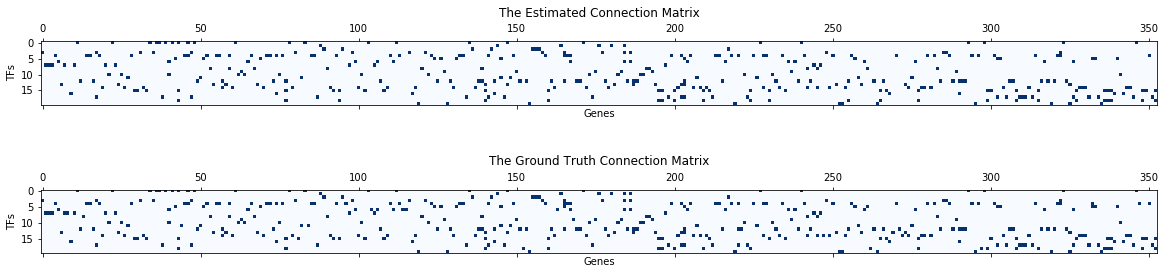

In [12]:
fig, axes = subplots(2,1,figsize=(20,5))
axes[0].matshow(conn.T,cmap=cm.Blues)
axes[0].set_title('The Estimated Connection Matrix\n')
axes[0].set_ylabel('TFs')
axes[0].set_xlabel('Genes')
axes[1].matshow(X_gt.T,cmap=cm.Blues)
axes[1].set_title('The Ground Truth Connection Matrix\n')
axes[1].set_ylabel('TFs')
axes[1].set_xlabel('Genes')

In [13]:
# Compare the estimated connection matrix with the ground-truth
X_p = X>0
print('Number of connections to infer: ' +str((X_p).sum()))
print('Number of used connections in ground truth: '+str(X_gt[X_p].sum()))
print('Number of not used connections in ground truth: '+str((X_p).sum()-X_gt[X_p].sum()))
print('Number of inferred used connections: '+str(conn[X_p].sum()))
print('Number of inferred not used connections: '+str((X_p).sum()-conn[X_p].sum()))
print('True Positive, True Negative: '+str((conn[X_p]*X_gt[X_p]).sum())+', '+str(((1-conn[X_p])*(1-X_gt[X_p])).sum()))
print('False Positive, False Negative: '+str((conn[X_p]*(1-X_gt[X_p])).sum())+', '+str(((1-conn[X_p])*(X_gt[X_p])).sum()))

Number of connections to infer: 469
Number of used connections in ground truth: 404
Number of not used connections in ground truth: 65
Number of inferred used connections: 391
Number of inferred not used connections: 78
True Positive, True Negative: 378, 52
False Positive, False Negative: 13, 26


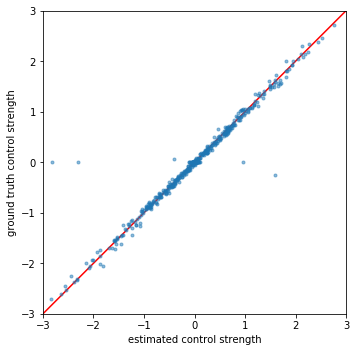

In [14]:
# Compare the estimated control strength with the ground-truth
sign_flip = np.sign((A*x_mean*X).sum(0))
x_mean_signcorrect = x_mean*sign_flip
fig = figure(figsize=(5,5),)
ax = fig.gca()
ax.set_aspect('equal')
ax.plot(np.linspace(-3,3,10),np.linspace(-3,3,10),'r-')
ax.plot(x_mean_signcorrect[X_p],A[X_p],'.',alpha=0.5)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_xlabel('estimated control strength')
ax.set_ylabel('ground truth control strength')
fig.tight_layout()

In [15]:
w_mean, w_std = m.sample_W(500)
w_mean *= sign_flip[:,None]
NCC = ((w_mean-w_mean.mean(1)[:,None])/w_mean.std(1)[:,None]*(P-P.mean(1)[:,None])/P.std(1)[:,None]).mean(1)

In [16]:
E_est = (conn*x_mean_signcorrect).dot(w_mean)
print('MSE (between the noise-free expression and the estimated expression): %f' % (((A.dot(P) - E_est)**2).mean()))

MSE (between the noise-free expression and the estimated expression): 0.008619


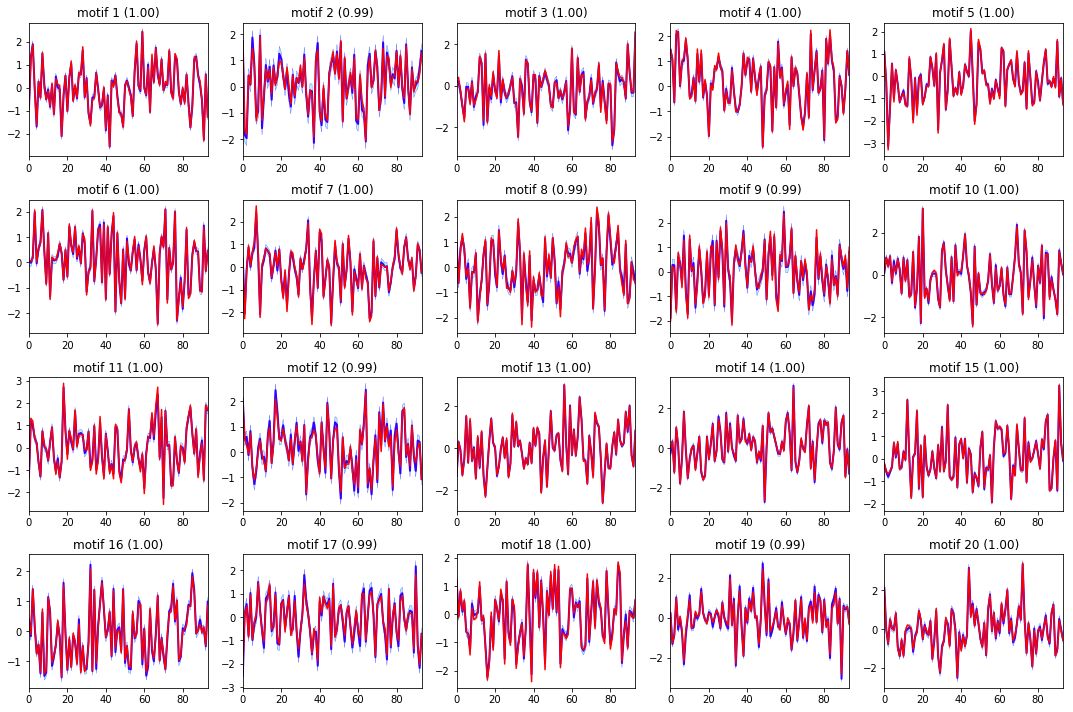

In [17]:
# Plot the individual TF activities and Compare with the ground-truth
# The values in the parentheses after the title shows the Pearson correlation with the ground-truth

fig_width = 5
fig, axes = subplots(int(ceil(num_tf/float(fig_width))),fig_width,figsize=(15,10))

for i in range(num_tf):
    gpplot(np.array(range(w_mean.shape[1])),
                    w_mean[i],w_mean[i]-1.96*w_std[i],w_mean[i]+1.96*w_std[i],
   ax=axes[i/fig_width][i%fig_width])
for i in range(num_tf):
    axes[i/fig_width][i%fig_width].plot(range(num_exp),P[i],'r')
for i in range(num_tf):
    plot_str = 'motif '+str(i+1)+' ('+'%.2f'%NCC[i]+')'
    axes[i/fig_width][i%fig_width].set_title(plot_str)
    axes[i/fig_width][i%fig_width].set_xlim(0,num_exp-1)
for i in range(num_tf, int(ceil(num_tf/float(fig_width)))*fig_width):
    axes[i/fig_width][i%fig_width].axis('off')
fig.tight_layout()